In [1]:
import numpy as np
import umap
import faiss
import scanpy as sc
import argparse
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #ignore warning about files we are using
from sklearn.metrics import adjusted_mutual_info_score

# parser = argparse.ArgumentParser(description='Unsupervised or Supervised Learning using UMAP, FAISS, and sklearn')
# parser.add_argument('-d','--data',help='unlabeled anndata input file',required=True)
# parser.add_argument('-k',type=int,help='Number of clusters to identify',required=False)
# parser.add_argument('-t','--train_data',help='labeled anndata file for training',required=False)
# parser.add_argument('-o','--output_file',help='Output file of cluster assignments (npy).',required=True)

# args = parser.parse_args()

In [2]:
# simulate the function parser - eval line 1
import os
os.chdir('/ihome/hpark/til177/GitHub/cobb2060-2026s/Data_cobb2060/proj3')
os.getcwd()
args = argparse.Namespace(
    data = 'mouse_spatial_brain_section0.h5ad',
    k = 4,
    train_data = np.nan,
    output_file = '/ihome/hpark/til177/GitHub/cobb2060-2026s/project3_/code/clusters.npy'
)
print(args.data, args.k, args.train_data, args.output_file)

mouse_spatial_brain_section0.h5ad 4 nan /ihome/hpark/til177/GitHub/cobb2060-2026s/project3_/code/clusters.npy


# Part I. Clustering 

In [3]:
adata = sc.read_h5ad(args.data)

                    in_tissue  array_row  array_col  n_counts  n_genes  \
AAACAAGTATCTCCCA-1          1         50        102    8751.0     2964   
AAACACCAATAACTGC-1          1         59         19   31736.0     6230   
AAACAGAGCGACTCCT-1          1         14         94   18720.0     5060   
AAACAGCTTTCAGAAG-1          1         43          9   12646.0     3923   
AAACAGGGTCTATATT-1          1         47         13   11493.0     3500   
...                       ...        ...        ...       ...      ...   
TTGTTCAGTGTGCTAC-1          1         24         64   13963.0     4331   
TTGTTGTGTGTCAAGA-1          1         31         77   17741.0     5784   
TTGTTTCACATCCAGG-1          1         58         42   29941.0     6641   
TTGTTTCATTAGTCTA-1          1         60         30   16840.0     4820   
TTGTTTCCATACAACT-1          1         45         27   21140.0     5408   

                   louvain             cell_ontology_class  
AAACAAGTATCTCCCA-1       2                 oligode

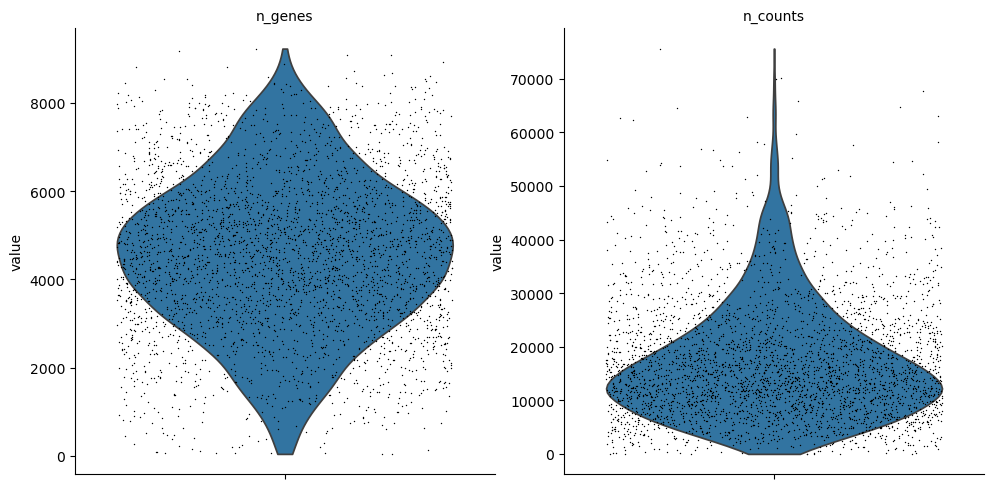

                          gene_ids    feature_types genome  highly_variable  \
Xkr4            ENSMUSG00000051951  Gene Expression   mm10            False   
Gm1992          ENSMUSG00000089699  Gene Expression   mm10            False   
Gm37381         ENSMUSG00000102343  Gene Expression   mm10            False   
Rp1             ENSMUSG00000025900  Gene Expression   mm10            False   
Sox17           ENSMUSG00000025902  Gene Expression   mm10            False   
...                            ...              ...    ...              ...   
AC168977.1      ENSMUSG00000079808  Gene Expression   mm10            False   
AC149090.1      ENSMUSG00000095041  Gene Expression   mm10            False   
CAAA01118383.1  ENSMUSG00000063897  Gene Expression   mm10            False   
Vmn2r122        ENSMUSG00000096730  Gene Expression   mm10            False   
CAAA01147332.1  ENSMUSG00000095742  Gene Expression   mm10            False   

                       means  dispersions  dispersi

In [48]:
# check the filtering status - already filtered/processed
print(adata.obs)
sc.pl.violin(
    adata,
    ["n_genes", "n_counts"],
    jitter=0.4,
    multi_panel=True,
)
print(adata.var)

In [49]:
# can use this for filtering
print(adata.var.highly_variable.sum())
adata

1999


AnnData object with n_obs × n_vars = 3353 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_genes', 'louvain', 'cell_ontology_class'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_ontology_class_colors', 'images', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'scalefactors', 'umap'
    obsm: 'X_pca', 'X_spatial', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [50]:
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 3353 × 18496
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_genes', 'louvain', 'cell_ontology_class'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells'
    uns: 'cell_ontology_class_colors', 'images', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'scalefactors', 'umap'
    obsm: 'X_pca', 'X_spatial', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [4]:
def unify_varnames(adata):
    adata.var_names = [v.split("_")[-1] for v in adata.var_names]
    adata.var_names_make_unique()

def preprocess_data(adata, min_cells=3, filtered_col_name = 'highly_variable'):    
    
    import scipy.sparse as sp
    # Check if data looks already log-normalized
    #     If max value is very large (>100), likely raw counts needing normalization
    max_val = adata.X.max() if not sp.issparse(adata.X) else adata.X.max()
    is_raw = max_val > 50

    if is_raw:
        # Save raw counts before normalization
        adata.layers["counts"] = adata.X.copy()
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
    
    ### Filter for HVGs ###
    sc.pp.filter_genes(adata, min_cells=min_cells)
    
    if filtered_col_name in adata.var.columns: #use this
        adata = adata[:,adata.var[filtered_col_name]].copy()
        print('\n>> Used column exisiting filter')
    
    else: # use built in filter_genes
        if is_raw:
            # seurat_v3 needs raw counts — use the counts layer
            sc.pp.highly_variable_genes(
                adata, n_top_genes=2000, flavor='seurat_v3', layer='counts'
            )
        else:
            sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat')
        adata = adata[:, adata.var['highly_variable']].copy()
        print('\n>> Computed highly_variable_genes')

    return adata

In [5]:
unify_varnames(adata)
adata_hvg = preprocess_data(adata)
adata_hvg

X = adata_hvg.X.toarray() if hasattr(adata_hvg.X, 'toarray') else adata_hvg.X
print(X.shape)


>> Used column exisiting filter
(3353, 1802)


In [55]:
(adata_hvg.obsm['X_pca'] == adata.obsm['X_pca']).all()

True

In [6]:
RANDOM_STATE = 42

#### Patch -- resolve the version conflict ####
import umap.umap_ as _umap_module

_orig = _umap_module.check_array

def _patched(*args, ensure_all_finite=True, **kwargs):
    kwargs['force_all_finite'] = ensure_all_finite
    return _orig(*args, **kwargs)

_umap_module.check_array = _patched
####

def umap_embed(X, n_components, n_neighbors, min_dist,
              random_state = RANDOM_STATE):
    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric="euclidean",
        random_state=random_state,
    )
    return reducer.fit_transform(X).astype(np.float32)

## Grid search for best hyperparameters

In [7]:
print("\nTesting selected UMAP parameters (k=4):")
print("=" * 60)

configs = [
    {'n_components': 10, 'n_neighbors': 15, 'min_dist': 0.1},
    {'n_components': 15, 'n_neighbors': 15, 'min_dist': 0.1},
    {'n_components': 20, 'n_neighbors': 15, 'min_dist': 0.1},
    {'n_components': 20, 'n_neighbors': 10, 'min_dist': 0.1},
    {'n_components': 20, 'n_neighbors': 20, 'min_dist': 0.1},
    {'n_components': 20, 'n_neighbors': 15, 'min_dist': 0.0},
    {'n_components': 25, 'n_neighbors': 15, 'min_dist': 0.1},
]

best_ami = 0
best_params = None

for config in configs:
    # calculate umap embeddings
    embedding = umap_embed(X,
                           n_components=config['n_components'], random_state=RANDOM_STATE, 
                           n_neighbors=config['n_neighbors'], min_dist=config['min_dist'])
    # train the kmeans
    kmeans = faiss.Kmeans(d=config['n_components'], k=4, niter=50, seed=RANDOM_STATE)
    kmeans.train(embedding)

    # mapping from embedding to the centroids (first arg is distance)
    _, cluster_ids = kmeans.index.search(embedding, 1)
    cluster_ids = cluster_ids.flatten()
    
    ami = adjusted_mutual_info_score(
        adata.obs['cell_ontology_class'].astype('category').cat.codes.values, 
        cluster_ids)
    print(f"n_comp={config['n_components']:2d}, n_neighbors={config['n_neighbors']:2d}, min_dist={config['min_dist']:.1f}: AMI={ami:.4f}")
    
    if ami > best_ami:
        best_ami = ami
        best_params = config

print(f"\nBest params: {best_params} with AMI={best_ami:.4f}")



Testing selected UMAP parameters (k=4):


/ix/ccdg/storage3/til177/custom_miniconda/envs/hugen_general/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_comp=10, n_neighbors=15, min_dist=0.1: AMI=0.4962


/ix/ccdg/storage3/til177/custom_miniconda/envs/hugen_general/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_comp=15, n_neighbors=15, min_dist=0.1: AMI=0.5930


/ix/ccdg/storage3/til177/custom_miniconda/envs/hugen_general/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_comp=20, n_neighbors=15, min_dist=0.1: AMI=0.4990


/ix/ccdg/storage3/til177/custom_miniconda/envs/hugen_general/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_comp=20, n_neighbors=10, min_dist=0.1: AMI=0.4825


/ix/ccdg/storage3/til177/custom_miniconda/envs/hugen_general/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_comp=20, n_neighbors=20, min_dist=0.1: AMI=0.6019


/ix/ccdg/storage3/til177/custom_miniconda/envs/hugen_general/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_comp=20, n_neighbors=15, min_dist=0.0: AMI=0.5906


/ix/ccdg/storage3/til177/custom_miniconda/envs/hugen_general/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_comp=25, n_neighbors=15, min_dist=0.1: AMI=0.3901

Best params: {'n_components': 20, 'n_neighbors': 20, 'min_dist': 0.1} with AMI=0.6019


In [8]:
# Apply the best params
Kmeans_n_components = 20
Kmeans_n_neighbors  = 20
Kmeans_min_dist     = 0.1

embedding = umap_embed(X, random_state=RANDOM_STATE, 
                           n_components=Kmeans_n_components, 
                           n_neighbors=Kmeans_n_neighbors, 
                           min_dist=Kmeans_min_dist)
# train the kmeans
kmeans = faiss.Kmeans(d=Kmeans_n_components, #umap space
                       k=args.k, niter=50, seed=RANDOM_STATE)
kmeans.train(embedding)

/ix/ccdg/storage3/til177/custom_miniconda/envs/hugen_general/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


2998.947265625

In [9]:
# mapping from embedding to the centroids (first arg is distance)
_, cluster_ids = kmeans.index.search(embedding, 1)
I = cluster_ids.flatten()
print(I)

[3 1 0 ... 1 1 1]


# Part II. Supervised Learning -- Prediction of CellOntology

In [10]:
args = argparse.Namespace(
    data = 'mouse_cortex_methods_comparison_log1p_cpm_modified.h5ad',
    k = np.nan,
    train_data = 'mouse_spatial_brain_section0.h5ad',
    output_file = '/ihome/hpark/til177/GitHub/cobb2060-2026s/project3_/code/clusters.npy'
)
print(args.data, args.k, args.train_data, args.output_file)

mouse_cortex_methods_comparison_log1p_cpm_modified.h5ad nan mouse_spatial_brain_section0.h5ad /ihome/hpark/til177/GitHub/cobb2060-2026s/project3_/code/clusters.npy


In [11]:
train_adata = sc.read_h5ad(args.train_data)
test_adata  = sc.read_h5ad(args.data)

In [12]:
print(train_adata)
print(test_adata)

AnnData object with n_obs × n_vars = 3353 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_genes', 'louvain', 'cell_ontology_class'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_ontology_class_colors', 'images', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'scalefactors', 'umap'
    obsm: 'X_pca', 'X_spatial', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
AnnData object with n_obs × n_vars = 2345 × 23717
    obs: 'nGene', 'nUMI'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells'
    uns: 'connectivities_key', 'distances_key', 'params', 'rp_forest'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [18]:
train_adata = sc.read_h5ad(args.train_data)
unify_varnames(train_adata)
test_adata  = sc.read_h5ad(args.data)
unify_varnames(test_adata)

# Align the gene names in train and test (before concat)
common = np.intersect1d(train_adata.var_names, test_adata.var_names)
print('Numb of common genes shared between two data:', len(common))
train_adata = train_adata[:, common].copy()
test_adata = test_adata[:, common].copy()

Numb of common genes shared between two data: 22603


In [19]:
# preprocess
train_adata = preprocess_data(train_adata)
test_adata = preprocess_data(test_adata)


>> Used column exisiting filter

>> Used column exisiting filter


In [20]:
combined = sc.concat([train_adata, test_adata], axis=0, #by obs/cells
                     join='inner')
print(f'Combined data shape: {combined.shape}')
# convert to array (handle sparse mat)
X = combined.X.toarray() if hasattr(combined.X, 'toarray') else combined.X

# compute UMAP embedding on combined data
#       this allows a better manifold distribution in the test set by providing ground truth labels
embedding = umap_embed(X, random_state=RANDOM_STATE, 
                        n_components=Kmeans_n_components, 
                        n_neighbors=Kmeans_n_neighbors, 
                        min_dist=Kmeans_min_dist)
# Split back into train and test
n_train = train_adata.n_obs
X_train_umap = embedding[:n_train]
X_test_umap = embedding[n_train:]


/ix/ccdg/storage3/til177/custom_miniconda/envs/hugen_general/lib/python3.11/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/ix/ccdg/storage3/til177/custom_miniconda/envs/hugen_general/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Combined data shape: (5698, 242)


In [51]:
print(combined)
print(combined.obsm['X_pca'])
print(combined.obsm['X_pca'].shape)

AnnData object with n_obs × n_vars = 5698 × 242
    obsm: 'X_pca', 'X_umap'
[[ 31.227375     2.7134554  -17.470156   ...   1.3118898    2.9634514
   -0.18348897]
 [-16.001186   -14.152278     2.7417736  ...  -1.1371863    4.0993094
   -0.07598823]
 [-12.340358    20.973019     9.151033   ...  -1.2880286    2.413211
    5.121045  ]
 ...
 [ -0.19221382  -1.0374222    9.809685   ...  -5.3999047   -0.6358206
   -0.41260648]
 [  7.4491377    0.75742435   7.364618   ...  -0.4682346   -1.3945949
    1.4074515 ]
 [  2.1794045   -1.1688137    6.0474863  ...  -2.202601    -1.1022283
   -1.0202768 ]]
(5698, 50)


In [24]:
y = train_adata.obs["cell_ontology_class"].astype(str).to_numpy()
from collections import Counter
print('Ground Truth Labels:', Counter(y))

Ground Truth Labels: Counter({'neuron': 1582, 'astrocyte': 760, 'oligodendrocyte': 598, 'oligodendrocyte precursor cell': 413})


In [27]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)
print(y[:5])
print(y_enc[:5])

['oligodendrocyte' 'neuron' 'oligodendrocyte precursor cell' 'neuron'
 'astrocyte']
[2 1 3 1 0]


## CV on labeled data -> Best Classifier

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, adjusted_mutual_info_score

Note: do the CV based on the __common-feautre-filtered train data__

In [37]:
print(X_train_umap.shape)
print(y_enc.shape)
print("Testing different classifiers for supervised labeling:")
print("=" * 70)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
classifiers = { #default hyperparam
    'KNN_5':  KNeighborsClassifier(n_neighbors=5),
    'KNN_10': KNeighborsClassifier(n_neighbors=10),
    'KNN_15': KNeighborsClassifier(n_neighbors=15),
    'KNN_20': KNeighborsClassifier(n_neighbors=20),
    
    'ElasticNet': LogisticRegression(
        penalty='elasticnet', # deprecated in the newest ver, but required here
        solver='saga', l1_ratio=0.5, C=0.1,
        max_iter=1000, tol=1e-3, class_weight='balanced', random_state=RANDOM_STATE
    ),
    
    'SVM_rbf': SVC(kernel='rbf', random_state=RANDOM_STATE), # didnt test linear due to its simplicity
    
    'XGBoost': XGBClassifier(
        n_estimators=100, 
        max_depth=3, #for multiclass, rather than 2
        learning_rate=0.1,
        random_state=RANDOM_STATE, n_jobs=-1, 
        eval_metric='mlogloss', #multiclass
        tree_method='hist' # modern option, faster/local
    ),
    'RF_100': RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
    'RF_200': RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
}

#### CV ####
best_ami = 0
best_clf_name = None

for name, clf in classifiers.items():
    predictions = cross_val_predict(clf, X_train_umap, y_enc, cv=cv)
    ami = adjusted_mutual_info_score(y_enc, predictions)
    print(f"{name:25s}: AMI={ami:.4f}")
    if ami > best_ami:
        best_ami = ami
        best_clf_name = name

print(f"\nBest classifier: {best_clf_name} with AMI={best_ami:.4f}")

(3353, 20)
(3353,)
Testing different classifiers for supervised labeling:
KNN_5                    : AMI=0.6096
KNN_10                   : AMI=0.6062
KNN_15                   : AMI=0.6073
KNN_20                   : AMI=0.6090
ElasticNet               : AMI=0.4331
SVM_rbf                  : AMI=0.3776
XGBoost                  : AMI=0.6235
RF_100                   : AMI=0.6210
RF_200                   : AMI=0.6241

Best classifier: RF_200 with AMI=0.6241


## Grid search for best type of classifier

In [44]:
# Grid search for RF_200
ami_scorer = make_scorer(adjusted_mutual_info_score)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15, None], # None = no limit
    'max_features': ['sqrt', 'log2', 0.3],
    # 'bootstrap': [True, False], 'max_samples': [None, 0.1, 0.5, 1.0],#associated with bootstrap
    # 'class_weight': ['balanced', 'balanced_subsample', None],
}

rf = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=cv,
    scoring=ami_scorer,
    n_jobs=-1,
    refit=True,
    verbose=3,
)
grid_search.fit(X_train_umap, y_enc)

print(f"\nBest params: {grid_search.best_params_}")
print(f"Best AMI:    {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best params: {'max_depth': 10, 'max_features': 0.3, 'n_estimators': 500}
Best AMI:    0.6279
[CV 1/5] END max_depth=5, max_features=sqrt, n_estimators=500;, score=0.637 total time=   3.0s
[CV 3/5] END max_depth=5, max_features=0.3, n_estimators=500;, score=0.588 total time=   4.7s
[CV 2/5] END max_depth=10, max_features=0.3, n_estimators=100;, score=0.642 total time=   1.5s
[CV 1/5] END max_depth=10, max_features=0.3, n_estimators=200;, score=0.627 total time=   2.6s
[CV 2/5] END max_depth=15, max_features=sqrt, n_estimators=200;, score=0.638 total time=   2.2s
[CV 4/5] END max_depth=15, max_features=log2, n_estimators=100;, score=0.621 total time=   2.2s
[CV 2/5] END max_depth=15, max_features=log2, n_estimators=500;, score=0.637 total time=   6.1s
[CV 1/5] END max_depth=None, max_features=sqrt, n_estimators=500;, score=0.635 total time=   5.1s
[CV 4/5] END max_depth=None, max_features=0.3, n_estimators=100;, score=0.615 t

## Final Fit

In [46]:
clf = RandomForestClassifier(n_estimators=500, max_depth=10, max_features=0.3, 
                             class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
clf.fit(X_train_umap, y_enc)

# Predict
print(clf.predict(X_test_umap))
I = le.inverse_transform( #get the label (cellontology) back
    clf.predict(X_test_umap)
)
print(I)
print(Counter(I))

[2 2 2 ... 2 2 2]
['oligodendrocyte' 'oligodendrocyte' 'oligodendrocyte' ...
 'oligodendrocyte' 'oligodendrocyte' 'oligodendrocyte']
Counter({'oligodendrocyte': 2182, 'oligodendrocyte precursor cell': 159, 'neuron': 4})
